## Dependencies and Data

In [422]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer
import numpy as np
import math 
import rfpimp

In [209]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [3]:
print(retail_areas.dtypes)

date                                                       object
id                                                        float64
events                                                    float64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local Footprint Name                                       object
Region                                                     object
Base Score                                                float64
Retail Footprint Score                                    float64
Residential Population (Weighted Catchment)               float64
Spend Per Head (Residential)                              float64
Sparsity                                                   object
Longitude                                                 float64
Latitude                                                  float64
Tourism Sc

In [4]:
print("Number of unique Local_Footprint_Centre_ID:", retail_areas['Local_Footprint_Centre_ID'].nunique())
print("Total number of rows:", len(retail_areas))

Number of unique Local_Footprint_Centre_ID: 1207
Total number of rows: 437686


In [5]:
unique_days = retail_areas.loc[retail_areas['mean_wind'].isna(), 'date'].unique()
unique_days_sorted = sorted(unique_days)
print("Unique days with missing mean_wind:", unique_days_sorted)

Unique days with missing mean_wind: ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-25', '2024-02-09', '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-23', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-07-05', '2024-07-06', '2024-07-07', '2024-08-05', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-28', '2024-08-29', '2024-08-30', '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-11', '2024-10-07', '2024-10-12', '2024-10-13', '2024-10-30

# Modelling

## 1.1. Model Prep

### 1.1.1. Check for linear relationships

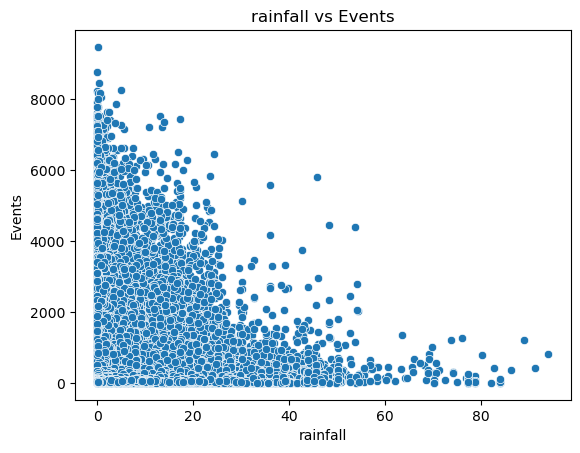

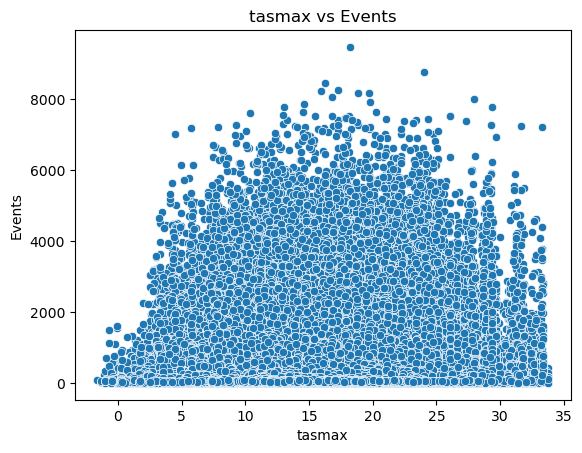

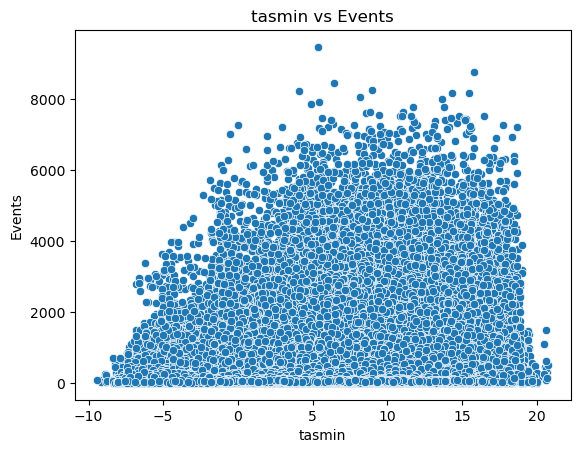

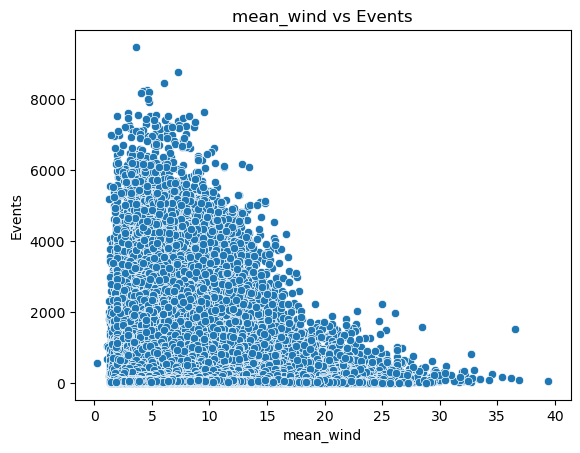

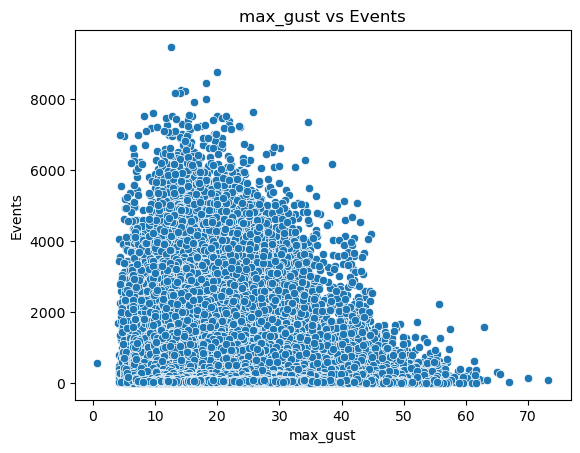

In [6]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.scatterplot(x=var, y='events', data=retail_areas)
    plt.title(f'{var} vs Events')
    plt.xlabel(var)
    plt.ylabel('Events')
    plt.show()

### 1.1.2. Variable encoding

In [210]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=False)

# define weather variables
weather_vars = ['rainfall', 'tasmax', 'mean_wind']

# calculate mean annual footfall for each location
location_means = df_model.groupby('Local_Footprint_Centre_ID')['events'].mean().rename('location_mean_footfall')
# merge back to dataframe
df_model = df_model.merge(location_means, on='Local_Footprint_Centre_ID')

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score                680
Major_Class_Name             729
Minor_Class_Name             729
Seasonality_Class_Name       729
rainfall                    3976
tasmax                      3976
tasmin                      3976
mean_wind                 132578
max_gust                  132578
dtype: int64
Rows with at least one missing value: 136340
Total rows before drop: 437686
Total rows after drop: 301346


## 2.1. General Model

### 2.1.1. Most basic (baseline + CACI indicators)

Set up:

In [8]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score'
]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [9]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1173
2024-01-16    1177
2024-01-17    1170
2024-01-18    1176
2024-01-19    1178
              ... 
2024-11-20    1181
2024-11-25    1182
2024-11-26    1179
2024-11-27    1184
2024-12-02    1181
Name: id, Length: 255, dtype: int64


Hyperparameters:

In [10]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=20, min_samples_split=8; total time=  13.0s
[CV] END .................max_depth=20, min_samples_split=10; total time=  13.1s
[CV] END ..................max_depth=30, min_samples_split=4; total time=  13.0s
[CV] END .................max_depth=30, min_samples_split=10; total time=  13.0s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  13.1s
[CV] END ..................max_depth=30, min_samples_split=8; total time=  13.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  14.2s
[CV] END ..................max_depth=40, min_samples_split=4; total time=  13.1s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  13.0s
[CV] END ..................max_depth=50, min_samples_split=2; total time=  13.1s
[CV] END .................max_depth=40, min_samples_split=10; total time=  13.0s
[CV] END .................max_depth=40, min_samples_split=10; total time=  13.4s
[CV] END ..................m

Implement random forest:

In [11]:
rf_final = RandomForestRegressor(**clf.best_params_, 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

In [12]:
# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9042 ± 0.0006
Mean Train RMSE: 194.1810 ± 0.2832
Mean Test R²: 0.9031 ± 0.0025
Mean Test RMSE: 195.2197 ± 1.1159


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.811161
Tourism Score                                  0.001206
Leisure_Footprint_Score                        0.000522
Retail Footprint Score                         0.000092
Residential Population (Weighted Catchment)   -0.000502


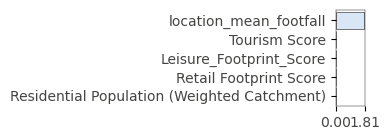

In [13]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 2.1.2. Add temporal vars

Set up:

In [4]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [5]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=2; total time=  24.7s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  24.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  24.8s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.2s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.2s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.4s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  24.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  24.9s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  24.9s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.0s
[CV] END ..................m

Implement random forest:

In [6]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

In [7]:
# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9434 ± 0.0005
Mean Train RMSE: 149.2551 ± 0.3986
Mean Test R²: 0.9362 ± 0.0024
Mean Test RMSE: 158.3101 ± 1.6639


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.747631
season_Autumn                                  0.016981
season_Summer                                  0.011149
weekend                                        0.009355
season_Spring                                  0.006930
season_Winter                                  0.006663
Leisure_Footprint_Score                        0.004655
Residential Population (Weighted Catchment)    0.003600
Tourism Score                                  0.001811
Retail Footprint Score                         0.001676
holiday                                        0.001185


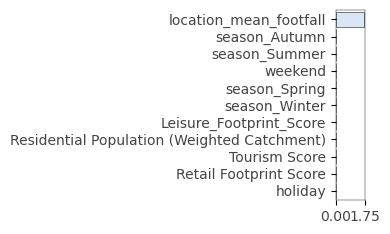

In [8]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 2.1.3. Add weather vars

Set up:

In [211]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + weather_vars

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [212]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.2min
[CV] END ..................m

Implement random forest:

In [213]:
rf_general_weather = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_general_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validated performance:

In [214]:
# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_general_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9726 ± 0.0003
Mean Train RMSE: 103.8875 ± 0.2288
Mean Test R²: 0.9376 ± 0.0021
Mean Test RMSE: 156.6046 ± 1.4393


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.851289
season_Autumn                                  0.030076
season_Summer                                  0.020904
weekend                                        0.020484
season_Winter                                  0.013071
tasmax                                         0.008306
season_Spring                                  0.007052
Tourism Score                                  0.005816
Retail Footprint Score                         0.004097
Residential Population (Weighted Catchment)    0.003828
Leisure_Footprint_Score                        0.002856
mean_wind                                      0.000934
holiday                                        0.000547
rainfall                                       0.000451


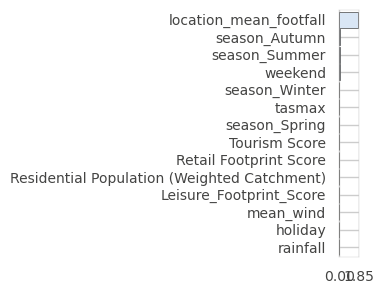

In [215]:
imp = rfpimp.importances(rf_general_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Partial dependence plots:

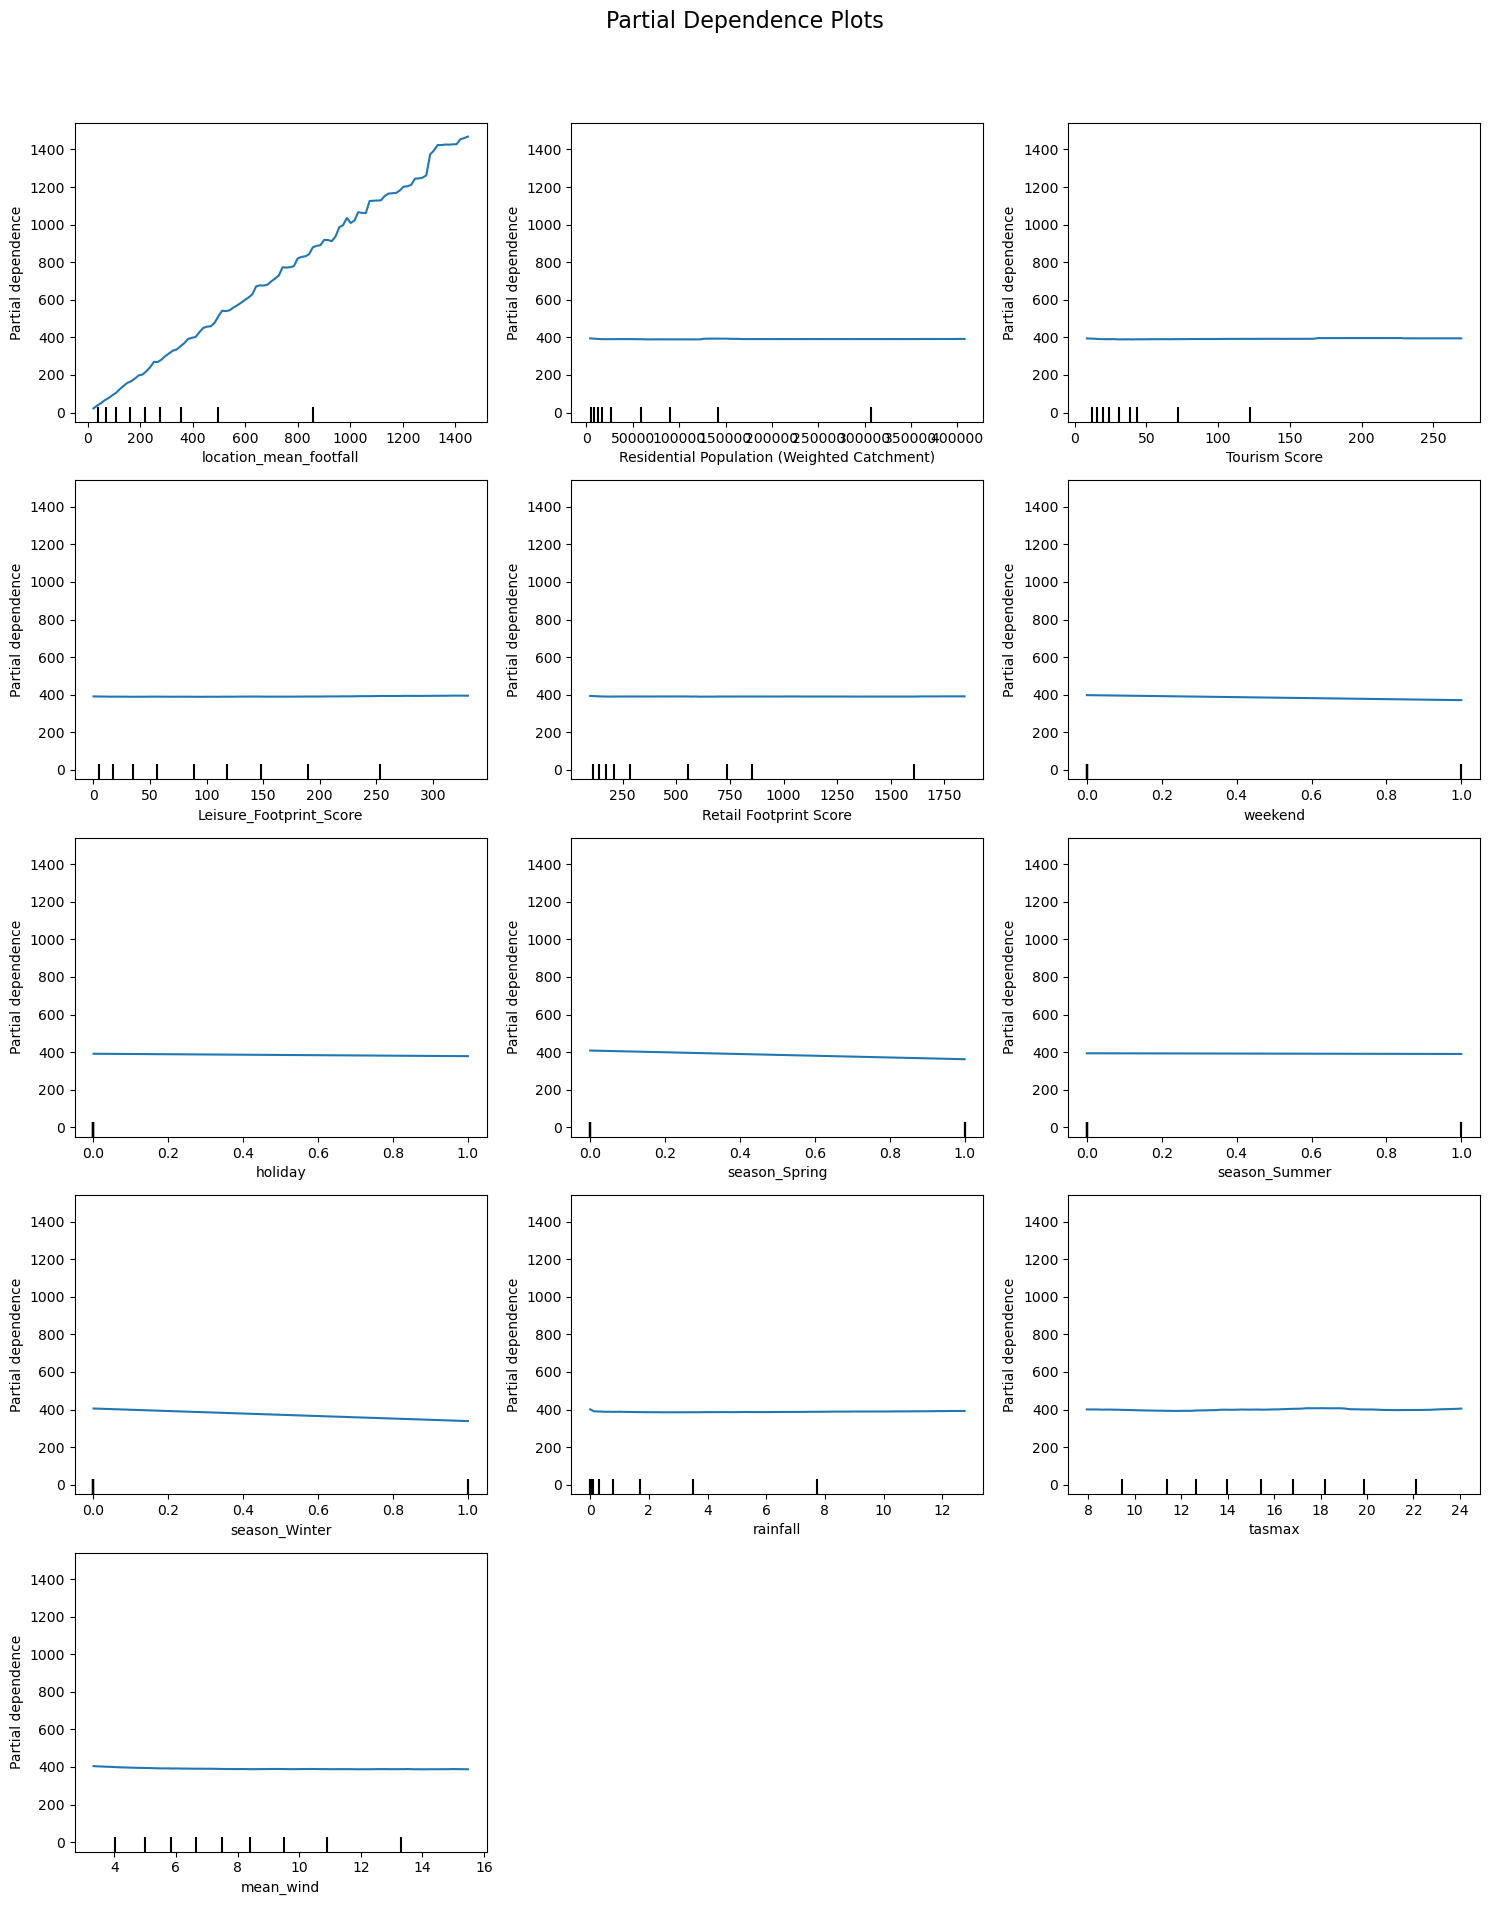

In [24]:
# format plots output
features = train_x.columns.tolist()
n_features = len(features) 
n_cols = 3
n_rows = -(-n_features // n_cols)  # ceiling division

# create subplots
fig1, ax1 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax1 = np.atleast_1d(ax1).flatten()

# plot PDPs
PartialDependenceDisplay.from_estimator(
    rf_general_weather,
    train_x,
    features=features,
    kind='average',     # PDP only
    centered=False,     # raw predictions
    ax=ax1[:n_features]
)

# remove empty subplots
for j in range(n_features, len(ax1)):
    fig1.delaxes(ax1[j])

plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 2.2. Model per retail type

### 2.2.1. With weather

Set up:

In [171]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'Tourism Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + weather_vars

Calibrate, cross-validate and plot partial dependence:


Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.983 ± 0.000
Train RMSE: 124.262 ± 0.496
Test R²: 0.956 ± 0.001
Test RMSE: 199.531 ± 3.196
Feature Importances:
location_mean_footfall                         0.931
tasmax                                         0.012
season_Spring                                  0.010
season_Winter                                  0.010
mean_wind                                      0.009
rainfall                                       0.007
weekend                                        0.005
Leisure_Footprint_Score                        0.005
Retail Footprint Score                         0.004
Residential Population (Weighted Catchment)    0.003
Tourism Score                                  0.002
season_Summer                                  0.001
holiday                                        0.001
dtype: float64


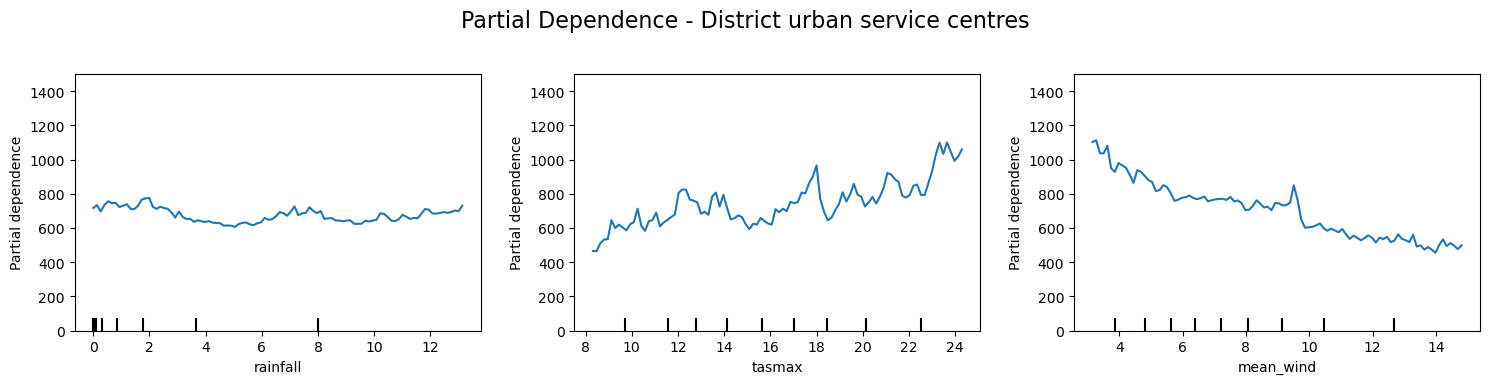


Group: Indie high streets
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.941 ± 0.001
Train RMSE: 102.041 ± 0.516
Test R²: 0.855 ± 0.004
Test RMSE: 159.688 ± 2.815
Feature Importances:
location_mean_footfall                         0.845
tasmax                                         0.035
mean_wind                                      0.029
rainfall                                       0.022
season_Winter                                  0.015
season_Spring                                  0.014
Tourism Score                                  0.008
weekend                                        0.008
Retail Footprint Score                         0.008
Leisure_Footprint_Score                        0.007
Residential Population (Weighted Catchment)    0.007
season_Summer                                  0.003
holiday                                        0.001
dtype: float64


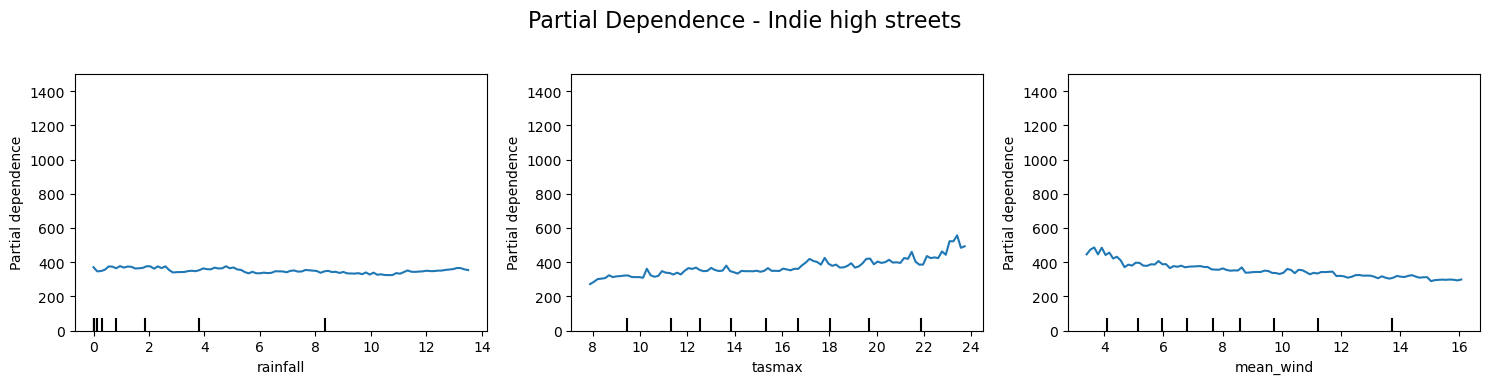


Group: Large regional retail and leisure destinations
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.967 ± 0.000
Train RMSE: 76.274 ± 0.363
Test R²: 0.921 ± 0.004
Test RMSE: 118.374 ± 1.800
Feature Importances:
location_mean_footfall                         0.900
tasmax                                         0.017
mean_wind                                      0.016
Leisure_Footprint_Score                        0.014
weekend                                        0.013
rainfall                                       0.012
season_Winter                                  0.005
Residential Population (Weighted Catchment)    0.005
Tourism Score                                  0.005
season_Spring                                  0.004
Retail Footprint Score                         0.004
holiday                                        0.003
season_Summer                                  0.002
dtype: float64


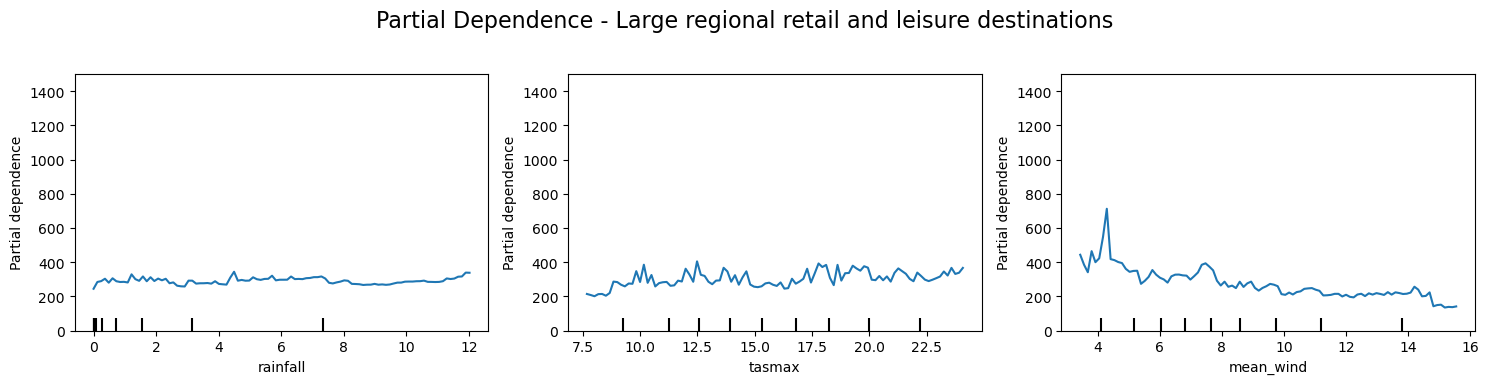


Group: Local urban convenience centres
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.957 ± 0.001
Train RMSE: 150.098 ± 1.755
Test R²: 0.930 ± 0.005
Test RMSE: 191.743 ± 7.342
Feature Importances:
location_mean_footfall                         0.876
Tourism Score                                  0.027
Residential Population (Weighted Catchment)    0.024
season_Spring                                  0.015
tasmax                                         0.015
season_Winter                                  0.015
mean_wind                                      0.009
rainfall                                       0.006
Leisure_Footprint_Score                        0.005
weekend                                        0.004
Retail Footprint Score                         0.003
season_Summer                                  0.001
holiday                                        0.000
dtype: float64


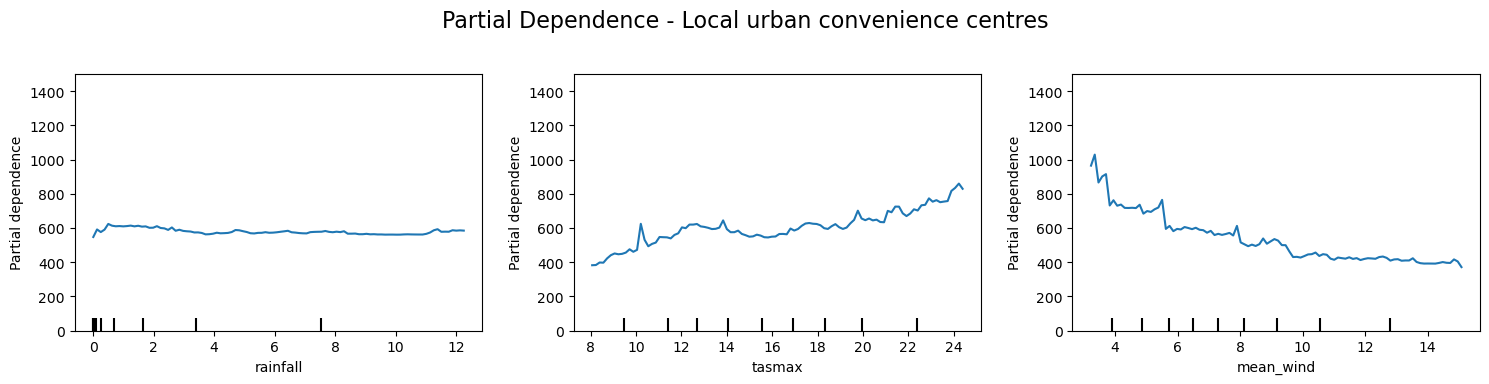


Group: Mass and value high streets
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.963 ± 0.001
Train RMSE: 99.074 ± 0.471
Test R²: 0.905 ± 0.008
Test RMSE: 157.433 ± 2.948
Feature Importances:
location_mean_footfall                         0.817
Retail Footprint Score                         0.028
Tourism Score                                  0.026
Leisure_Footprint_Score                        0.024
tasmax                                         0.023
Residential Population (Weighted Catchment)    0.021
mean_wind                                      0.020
rainfall                                       0.015
season_Winter                                  0.010
season_Spring                                  0.008
weekend                                        0.006
season_Summer                                  0.002
holiday                                        0.001
dtype: float64


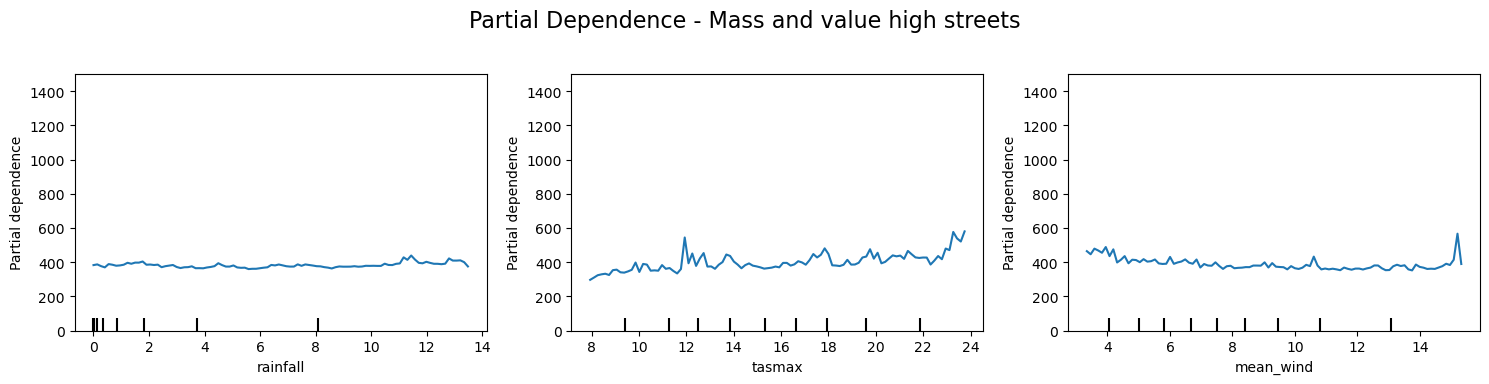


Group: Primary shopping centres and premium destinations
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.919 ± 0.004
Train RMSE: 109.964 ± 2.258
Test R²: 0.804 ± 0.028
Test RMSE: 169.533 ± 10.861
Feature Importances:
Retail Footprint Score                         0.404
location_mean_footfall                         0.379
tasmax                                         0.058
mean_wind                                      0.034
weekend                                        0.030
Leisure_Footprint_Score                        0.025
rainfall                                       0.024
season_Summer                                  0.012
Residential Population (Weighted Catchment)    0.009
season_Winter                                  0.009
Tourism Score                                  0.008
holiday                                        0.006
season_Spring                                  0.004
dtype: float64


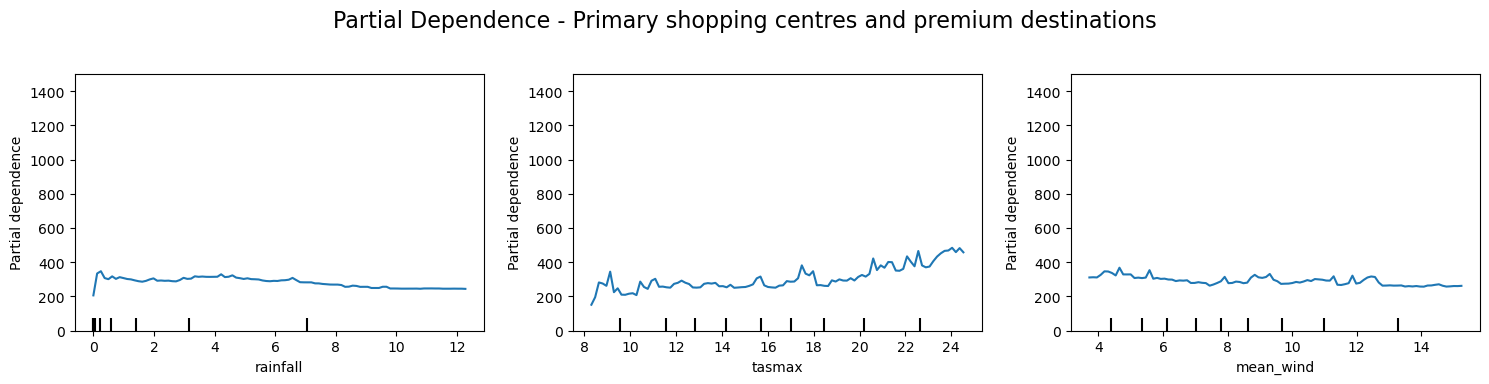


Group: Secondary retail parks and shopping centres
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.911 ± 0.002
Train RMSE: 124.876 ± 1.187
Test R²: 0.850 ± 0.012
Test RMSE: 161.649 ± 6.465
Feature Importances:
location_mean_footfall                         0.852
season_Spring                                  0.032
season_Winter                                  0.031
tasmax                                         0.024
mean_wind                                      0.020
rainfall                                       0.013
weekend                                        0.006
Residential Population (Weighted Catchment)    0.005
Retail Footprint Score                         0.004
Tourism Score                                  0.004
Leisure_Footprint_Score                        0.004
season_Summer                                  0.004
holiday                                        0.001
dtype: float64


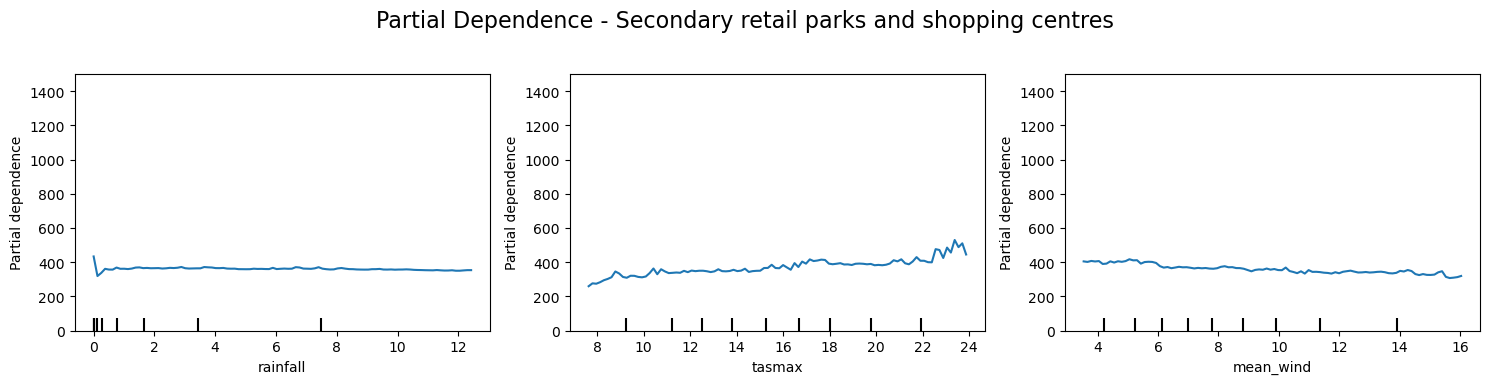


Group: Sub-regional retail and leisure destinations
Best parameters: {'max_depth': 40, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.983 ± 0.000
Train RMSE: 98.660 ± 0.657
Test R²: 0.955 ± 0.002
Test RMSE: 160.234 ± 3.380
Feature Importances:
location_mean_footfall                         0.938
tasmax                                         0.011
mean_wind                                      0.009
season_Winter                                  0.007
rainfall                                       0.007
season_Spring                                  0.007
Tourism Score                                  0.007
Leisure_Footprint_Score                        0.006
weekend                                        0.003
Residential Population (Weighted Catchment)    0.002
Retail Footprint Score                         0.002
season_Summer                                  0.001
holiday                                        0.001
dtype: float64


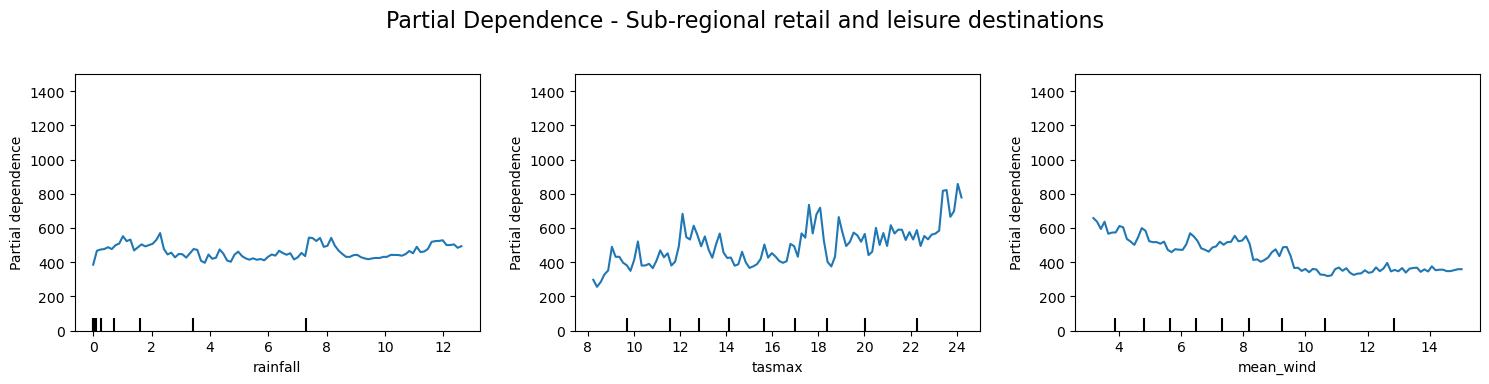

In [172]:
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # split features/target
    X = group_data[features]
    y = group_data[target]

    # split into train/test
    train_x, test_x, train_y, test_y = train_test_split(
        X, y,
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {
        'max_depth': [10, 20, 30, 40, 50],
        'min_samples_split': [2, 4, 6, 8, 10]
    }
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    best_params = clf.best_params_
    print(f"\nGroup: {name}")
    print("Best parameters:", best_params)

    # cross-validation on full group
    model = RandomForestRegressor(random_state=randomState_dt, **best_params)
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    cv_results = cross_validate(
        model,
        X, y,
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize CV metrics
    def summarize(metric):
        mean_val = np.mean(cv_results[f'train_{metric}'])
        std_val = np.std(cv_results[f'train_{metric}'])
        mean_test = np.mean(cv_results[f'test_{metric}'])
        std_test = np.std(cv_results[f'test_{metric}'])
        return mean_val, std_val, mean_test, std_test

    train_r2, std_train_r2, test_r2, std_test_r2 = summarize('r2')
    train_rmse, std_train_rmse, test_rmse, std_test_rmse = summarize('rmse')
    train_rmse, test_rmse = -train_rmse, -test_rmse  # invert negative RMSE

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {test_rmse:.3f} ± {std_test_rmse:.3f}")

    # final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)
    print("Feature Importances:")
    print(importances.round(3))

    # partial Dependence Plots for weather_vars
    X_weather = group_data[weather_vars].copy()
    model_weather = RandomForestRegressor(random_state=randomState_dt, **best_params).fit(X_weather, y)

    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    PartialDependenceDisplay.from_estimator(
        model_weather,
        X_weather,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 2.3. Temp Simulation

In [205]:
print(df_model.columns)

Index(['date', 'id', 'events', 'weekend', 'holiday', 'Local Footprint Name',
       'Base Score', 'Retail Footprint Score',
       'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Longitude', 'Latitude',
       'Tourism Score', 'Local_Footprint_Centre_ID',
       'Local_Footprint_Centre_Name', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       'Services_Provided:_Auto_Dealers'

### 2.3.1. All seasons

In [393]:
# use entire test set
all_idx = test_x.index
test_all = test_x.loc[all_idx]

# create copies for temperature scenarios
test_min = test_all.copy()
test_max = test_all.copy()

# tasmax column from full dataset
tasmax_all = df_model['tasmax'] 

# calculate quantiles
temp_min = tasmax_all.quantile(0.25)
temp_max = tasmax_all.quantile(0.75)

print(f"25th percentile temp: {temp_min:.1f}°C")
print(f"75th percentile temp: {temp_max:.1f}°C")

# set temperature
temp_col = 'tasmax'
test_min[temp_col] = temp_min
test_max[temp_col] = temp_max
#test_min[temp_col] = 10
#est_max[temp_col] = 15

# predict footfall
pred_min = rf_general_weather.predict(test_min)
pred_max = rf_general_weather.predict(test_max)

# compute difference
diff = pred_max - pred_min

# build results DataFrame
df_sim = test_all.copy()
df_sim['Local_Footprint_Centre_ID'] = df_model.loc[all_idx, 'Local_Footprint_Centre_ID']
df_sim['Local Footprint Name'] = df_model.loc[all_idx, 'Local Footprint Name']
df_sim['groupName'] = df_model.loc[all_idx, 'groupName']
df_sim['pred_min'] = pred_min
df_sim['pred_max'] = pred_max
df_sim['footfall_diff'] = diff
df_sim['relative_change'] = (df_sim['footfall_diff'] / df_sim['pred_min'].replace(0, np.nan)) * 100

# aggregate stats per location (all rows belonging to that location)
loc_stats = (
    df_sim.groupby('Local Footprint Name')['relative_change']
    .agg(median='median', mean='mean', std='std', count='count')
    .reset_index()
)

# merge groupName from df_sim back to loc_stats
loc_stats = loc_stats.merge(
    df_sim[['Local Footprint Name', 'groupName']].drop_duplicates(),
    left_on='Local Footprint Name',
    right_on='Local Footprint Name',
    how='left'
)

25th percentile temp: 12.0°C
75th percentile temp: 19.0°C


Per location:

In [394]:
# show top 10 locations by mean relative change
top_mean_locs = loc_stats.sort_values('mean', ascending=False).head(10)

print("Top 10 Locations with Highest Mean Predicted Footfall Increase:")
display(top_mean_locs)

# show top 10 locations by median relative change
top_median_locs = loc_stats.sort_values('median', ascending=False).head(10)

print("Top 10 Locations with Highest Median Predicted Footfall Increase:")
display(top_median_locs)

Top 10 Locations with Highest Mean Predicted Footfall Increase:


,Local Footprint Name,median,mean,std,count,groupName
373,Glasgow - St. Andrews Squ,67.949208,94.556393,69.339954,55,Large regional retail and leisure destinations
291,Edinburgh - Roxburgh Plac,62.624723,85.070588,62.863683,39,Large regional retail and leisure destinations
252,Dartmouth,57.944202,72.887614,65.023775,61,Indie high streets
799,Padstow,60.159331,69.384779,56.749165,45,Indie high streets
637,Looe,52.951297,66.940000,41.862504,49,Indie high streets
336,Glasgow - Cambridge Stree,13.894314,65.273855,96.273348,50,Large regional retail and leisure destinations
201,Chesterfield - Spire Walk,52.972476,60.689136,34.568390,50,Sub-regional retail and leisure destinations
320,Fort William,59.347325,59.261332,45.449743,62,Indie high streets
641,Loughton - Station Road,45.062330,57.427248,31.477603,28,Mass and value high streets
221,Colchester - Balkerne Gat,41.295870,53.632901,41.466507,43,Large regional retail and leisure destinations


Top 10 Locations with Highest Median Predicted Footfall Increase:


,Local Footprint Name,median,mean,std,count,groupName
373,Glasgow - St. Andrews Squ,67.949208,94.556393,69.339954,55,Large regional retail and leisure destinations
291,Edinburgh - Roxburgh Plac,62.624723,85.070588,62.863683,39,Large regional retail and leisure destinations
799,Padstow,60.159331,69.384779,56.749165,45,Indie high streets
320,Fort William,59.347325,59.261332,45.449743,62,Indie high streets
252,Dartmouth,57.944202,72.887614,65.023775,61,Indie high streets
72,Borehamwood - Fairway Ave,55.277512,50.976208,37.106425,41,Mass and value high streets
201,Chesterfield - Spire Walk,52.972476,60.689136,34.568390,50,Sub-regional retail and leisure destinations
637,Looe,52.951297,66.940000,41.862504,49,Indie high streets
389,Gloucester - The Docks,50.924174,40.979109,47.253343,53,Primary shopping centres and premium destinations
885,Shanklin,49.058771,43.575765,44.069175,47,Indie high streets


Per retail type:

In [395]:
# group by groupName and compute mean/median of location-level stats
group_stats = (
    loc_stats.groupby('groupName')
    .agg(
        median=('median', 'median'),  # mean of per-location medians
        mean=('mean', 'mean'),        # mean of per-location means
        std=('mean', 'std'),          # std of per-location means
        count_locations=('count', 'sum')       # total rows (e.g. test rows) per group
    )
    .reset_index()
)

display(group_stats.sort_values('median', ascending=False))


,groupName,median,mean,std,count_locations
5,Primary shopping centres and premium destinations,8.846305,14.700327,14.434637,488
1,Indie high streets,4.919947,9.288011,12.895850,16226
7,Sub-regional retail and leisure destinations,4.181533,7.947171,11.036736,14518
4,Mass and value high streets,3.750297,6.637011,10.111502,5738
2,Large regional retail and leisure destinations,3.562540,7.345731,13.236127,12690
6,Secondary retail parks and shopping centres,3.327067,7.939555,9.621475,2035
3,Local urban convenience centres,1.566069,5.709783,11.142453,2142
0,District urban service centres,0.683612,2.949716,7.131044,6923


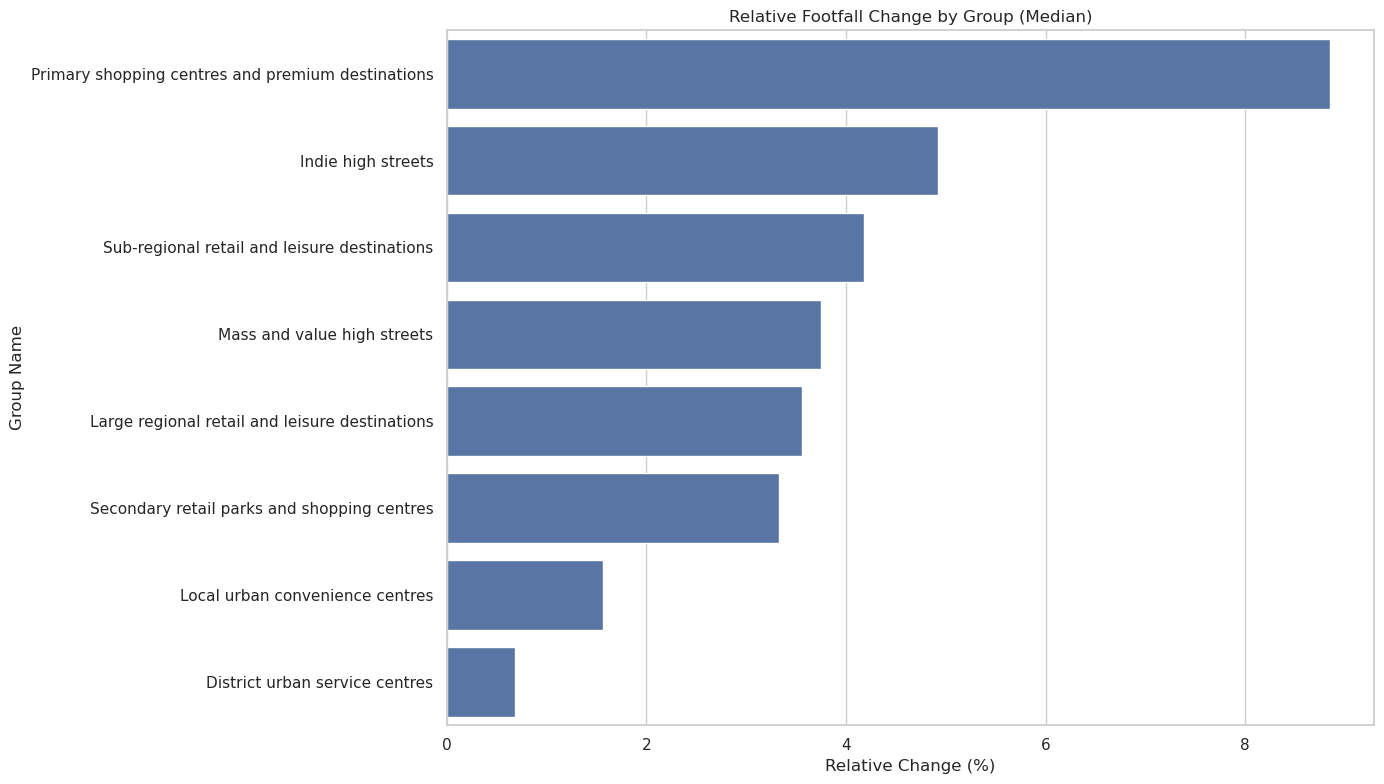

In [396]:
# sort by median
group_stats_sorted = group_stats.sort_values(by='median', ascending=False)

# melt to long format
df_melted = group_stats_sorted.melt(
    id_vars='groupName',
    value_vars=['median'],
    var_name='stat_type',
    value_name='relative_change'
)

# set plot size
plt.figure(figsize=(14, 8))

# barplot
sns.barplot(
    data=df_melted,
    y='groupName',
    x='relative_change',
    hue='stat_type',
    order=group_stats_sorted['groupName']
)

# labels and styling
plt.title('Relative Footfall Change by Group (Median)')
plt.xlabel('Relative Change (%)')
plt.ylabel('Group Name')
plt.tight_layout()
plt.legend('', frameon=False)
plt.show()

### 2.3.2. Season-specific

In [415]:
# filter rows
season_idx = test_x[df_model.loc[test_x.index, 'season_Winter'] == 1].index
test_x_season = test_x.loc[season_idx]

# create copies for temperature scenarios
test_min = test_x_season.copy()
test_max = test_x_season.copy()

# calculate quantiles
temp_min = test_x_season.loc[season_idx, 'tasmax'].quantile(0.25)
temp_max = test_x_season.loc[season_idx, 'tasmax'].quantile(0.75)

print(f"25th percentile temp: {temp_min:.1f}°C")
print(f"75th percentile temp: {temp_max:.1f}°C")

# set temperature
temp_col = 'tasmax'
test_min[temp_col] = temp_min
test_max[temp_col] = temp_max

# predict footfall
pred_min = rf_general_weather.predict(test_min)
pred_max = rf_general_weather.predict(test_max)

# compute difference
diff = pred_max - pred_min

# build results DataFrame
df_sim = test_x_season.copy()
df_sim['groupName'] = df_model.loc[season_idx, 'groupName']
df_sim['Local Footprint Name'] = df_model.loc[season_idx, 'Local Footprint Name']
df_sim['pred_min'] = pred_min
df_sim['pred_max'] = pred_max
df_sim['footfall_diff'] = diff
df_sim['relative_change'] = (df_sim['footfall_diff'] / df_sim['pred_min'].replace(0, np.nan)) * 100

# aggregate stats per location (all rows belonging to that location)
loc_stats = (
    df_sim.groupby('Local Footprint Name')['relative_change']
    .agg(median='median', mean='mean', std='std', count='count')
    .reset_index()
)

# merge groupName from df_sim back to loc_stats
loc_stats = loc_stats.merge(
    df_sim[['Local Footprint Name', 'groupName']].drop_duplicates(),
    left_on='Local Footprint Name',
    right_on='Local Footprint Name',
    how='left'
)

25th percentile temp: 8.8°C
75th percentile temp: 12.9°C


Per location:

In [416]:
# show top 10 locations by mean relative change
top_mean_locs = loc_stats.sort_values('mean', ascending=False).head(10)

print("Top 10 Locations with Highest Mean Predicted Footfall Increase:")
display(top_mean_locs)

# show top 10 locations by median relative change
top_median_locs = loc_stats.sort_values('median', ascending=False).head(10)

print("Top 10 Locations with Highest Median Predicted Footfall Increase:")
display(top_median_locs)

Top 10 Locations with Highest Mean Predicted Footfall Increase:


,Local Footprint Name,median,mean,std,count,groupName
1045,Weybridge - Church Street,103.219006,114.285899,38.930284,7,Indie high streets
956,Swanage,87.479164,90.085149,10.193525,9,Indie high streets
973,Tenby,75.237591,80.205593,24.574698,11,Indie high streets
15,Ammanford - Margaret Stre,77.228131,78.713234,25.371383,10,Indie high streets
1036,West Bromwich - West Brom,66.975192,75.771155,37.971956,14,Sub-regional retail and leisure destinations
365,Glasgow - Saltmarket,70.841824,69.802461,36.093817,13,Large regional retail and leisure destinations
447,High Barnet - Alston Road,74.956991,64.214845,33.966667,14,Indie high streets
201,Chesterfield - Spire Walk,55.105457,64.081063,24.757002,10,Sub-regional retail and leisure destinations
1094,Wrexham Central Railway S,39.407097,58.574732,31.540948,7,Sub-regional retail and leisure destinations
467,Keswick,55.483455,50.151524,17.136826,10,Indie high streets


Top 10 Locations with Highest Median Predicted Footfall Increase:


,Local Footprint Name,median,mean,std,count,groupName
1045,Weybridge - Church Street,103.219006,114.285899,38.930284,7,Indie high streets
956,Swanage,87.479164,90.085149,10.193525,9,Indie high streets
15,Ammanford - Margaret Stre,77.228131,78.713234,25.371383,10,Indie high streets
973,Tenby,75.237591,80.205593,24.574698,11,Indie high streets
447,High Barnet - Alston Road,74.956991,64.214845,33.966667,14,Indie high streets
365,Glasgow - Saltmarket,70.841824,69.802461,36.093817,13,Large regional retail and leisure destinations
1036,West Bromwich - West Brom,66.975192,75.771155,37.971956,14,Sub-regional retail and leisure destinations
467,Keswick,55.483455,50.151524,17.136826,10,Indie high streets
201,Chesterfield - Spire Walk,55.105457,64.081063,24.757002,10,Sub-regional retail and leisure destinations
349,Glasgow - Hill Street,49.210034,42.839738,21.465606,8,Large regional retail and leisure destinations


Per retail type:

In [417]:
# group by groupName and compute mean/median of location-level stats
group_stats = (
    loc_stats.groupby('groupName')
    .agg(
        median=('median', 'median'),  # median of per-location medians
        mean=('mean', 'mean'),        # mean of per-location means
        std=('mean', 'std'),          # std of per-location means
        count_locations=('count', 'sum')       # total rows (e.g. test rows) per group
    )
    .reset_index()
)

display(group_stats.sort_values('median', ascending=False))


,groupName,median,mean,std,count_locations
6,Secondary retail parks and shopping centres,4.460283,3.354887,8.998836,422
1,Indie high streets,2.483835,4.675689,14.312631,3463
3,Local urban convenience centres,2.424751,0.609921,8.373831,437
7,Sub-regional retail and leisure destinations,2.184401,3.121944,10.420338,3086
4,Mass and value high streets,2.139242,2.227654,8.270220,1205
0,District urban service centres,1.638896,2.519391,8.377487,1449
2,Large regional retail and leisure destinations,1.270194,1.718074,10.003077,2710
5,Primary shopping centres and premium destinations,1.002276,0.640197,4.756711,106


Bar plot:

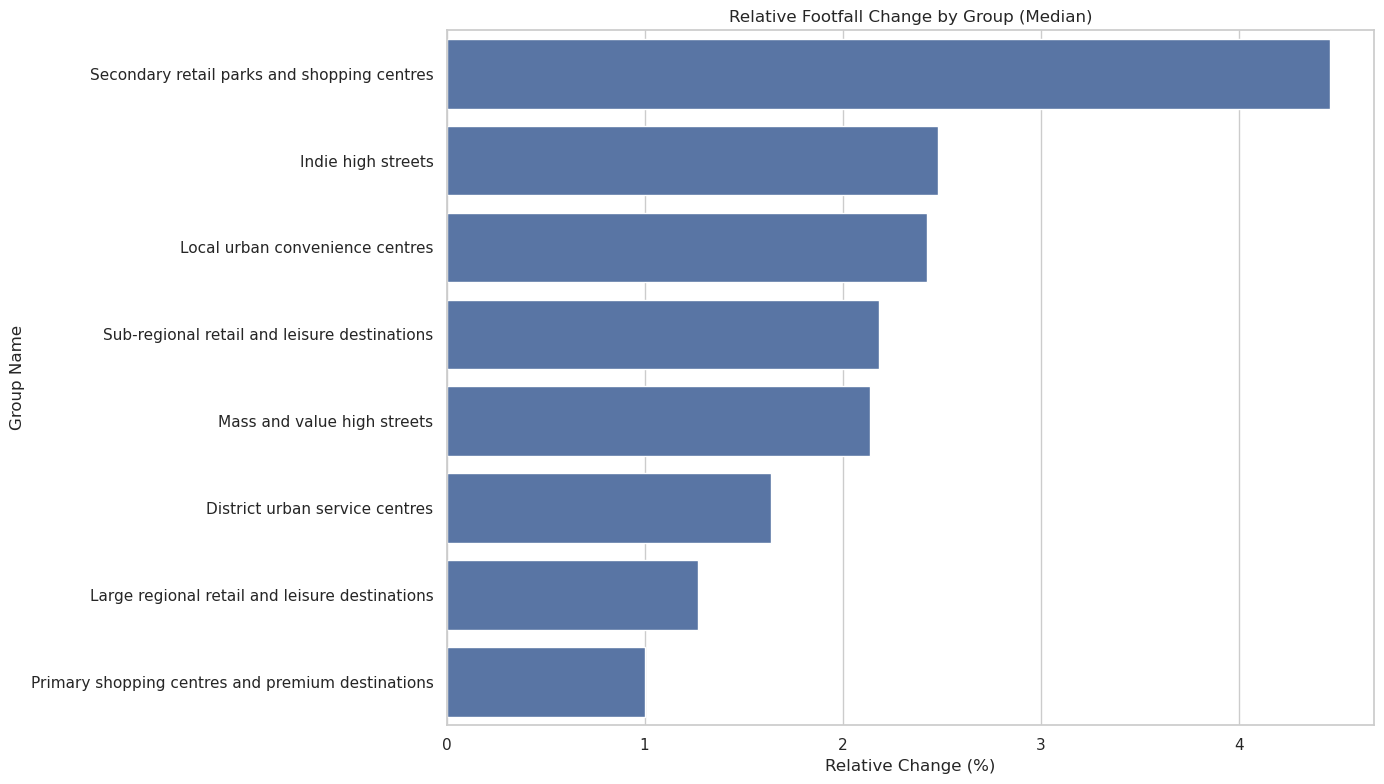

In [418]:
# Sort by median
group_stats_sorted = group_stats.sort_values(by='median', ascending=False)

# melt to long format
df_melted = group_stats_sorted.melt(
    id_vars='groupName',
    value_vars=['median'],
    var_name='stat_type',
    value_name='relative_change'
)

# set plot size
plt.figure(figsize=(14, 8))

# barplot
sns.barplot(
    data=df_melted,
    y='groupName',
    x='relative_change',
    hue='stat_type',
    order=group_stats_sorted['groupName']
)

# labels and styling
plt.title('Relative Footfall Change by Group (Median)')
plt.xlabel('Relative Change (%)')
plt.ylabel('Group Name')
plt.tight_layout()
plt.legend('', frameon=False)
plt.show()

Box plot:

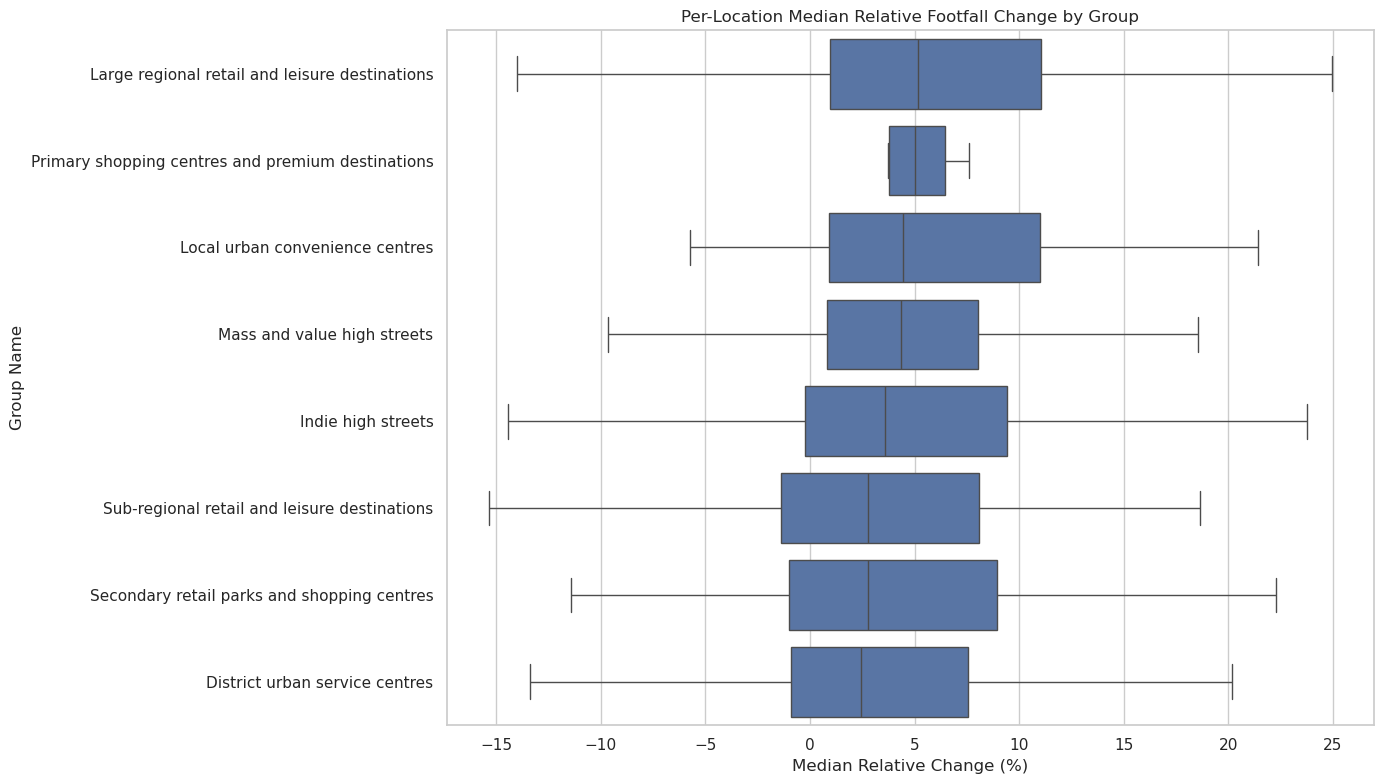

In [ ]:
plt.figure(figsize=(14, 8))

# order groups by overall median (across locations)
ordered_groups = (
    loc_stats.groupby('groupName')['median']
    .median()
    .sort_values(ascending=False)
    .index
)

sns.boxplot(
    data=loc_stats,
    y='groupName',
    x='median',
    order=ordered_groups,
    showfliers=False,
)

plt.title('Per-Location Median Relative Footfall Change by Group')
plt.xlabel('Median Relative Change (%)')s
plt.ylabel('Group Name')
plt.tight_layout()
plt.show()

### 2.3.3. Map results

In [439]:
gdf_map = retail_areas.merge(loc_stats, on='Local Footprint Name', how='left')

In [440]:
from shapely import wkt
gdf_map['geometry'] = gdf_map['geometry'].apply(wkt.loads)
print(type(gdf_map.geometry.iloc[0]))
print(gdf_map.geometry.head())

<class 'shapely.geometry.multipolygon.MultiPolygon'>
0    MULTIPOLYGON (((0.2833716834505971 51.47871162...
1    MULTIPOLYGON (((0.2833716834505971 51.47871162...
2    MULTIPOLYGON (((0.2833716834505971 51.47871162...
3    MULTIPOLYGON (((0.2833716834505971 51.47871162...
4    MULTIPOLYGON (((0.2833716834505971 51.47871162...
Name: geometry, dtype: object


In [441]:
gdf_map = gpd.GeoDataFrame(gdf_map, geometry='geometry', crs='EPSG:27700')
gdf_map['centroid'] = gdf_map.geometry.centroid
gdf_centroids = gpd.GeoDataFrame(gdf_map, geometry='centroid', crs=gdf_map.crs)

In [451]:
print(gdf_centroids['median'].head())
print(gdf_centroids['median'].describe())
print(gdf_centroids['median'].isna().sum())

0    5.188428
1    5.188428
2    5.188428
3    5.188428
4    5.188428
Name: median, dtype: float64
count    436684.000000
mean          2.931547
std          10.045958
min         -43.884661
25%          -1.936043
50%           2.032523
75%           6.151273
max         103.219006
Name: median, dtype: float64
4656


In [448]:
# load UK boundary shapefile
uk_boundary = gpd.read_file("Data/UK_boundary/gadm41_GBR_0.shp")
# convert CRS
uk_boundary = uk_boundary.to_crs(gdf_map.crs)

/tmp/ipykernel_683044/2053408510.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


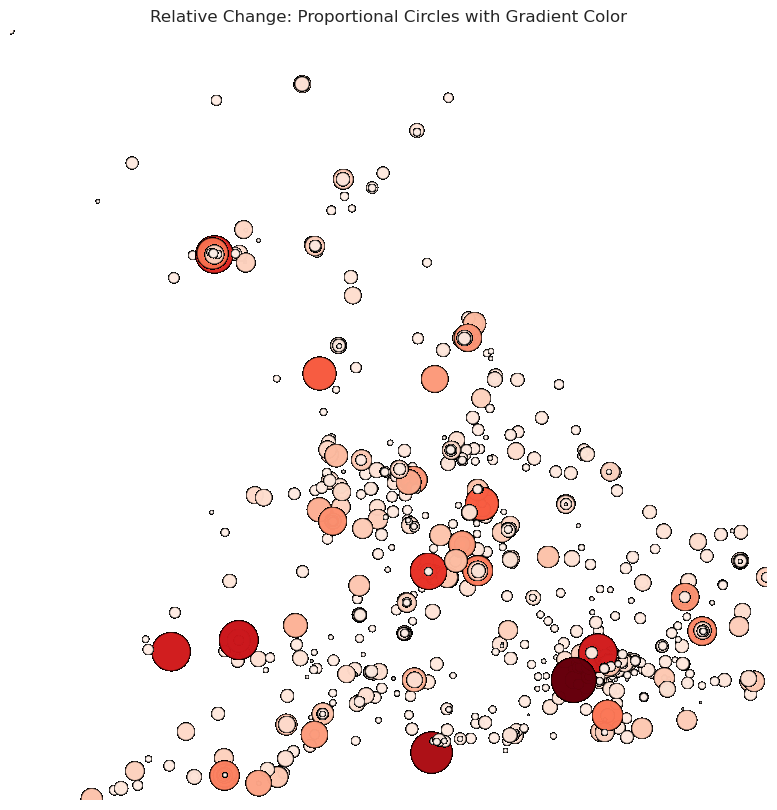

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot UK boundary first
uk_boundary.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Prepare sizes and colors
sizes = gdf_centroids['median'].abs() * 10  # adjust multiplier for visibility

# Normalize sizes for color mapping (0 = smallest, 1 = largest)
norm_sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)  # avoid div0

# Create a color map from light yellow (small) to red (large)
from matplotlib import cm
cmap = cm.get_cmap('Reds')

colors = cmap(norm_sizes)

# Plot points with proportional size, gradient colors, and alpha for translucency
gdf_centroids.plot(
    ax=ax,
    markersize=sizes,
    color=colors,
    alpha=0.2, 
    edgecolor='black',
    linewidth=0.5,
)

# Set zoom limits
ax.set_xlim(gdf_centroids.geometry.x.min() - 0.01, gdf_centroids.geometry.x.max() + 0.01)
ax.set_ylim(gdf_centroids.geometry.y.min() - 0.01, gdf_centroids.geometry.y.max() + 0.01)

plt.title('Relative Change')
plt.axis('off')
plt.show()


# Old

In [ ]:
# define target and features
target = 'events'

# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=6; total time=  28.2s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  31.0s
[CV] END ..................max_depth=30, min_samples_split=4; total time=  30.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  31.8s
[CV] END .................max_depth=30, min_samples_split=10; total time=  30.3s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  32.2s
[CV] END ..................max_depth=30, min_samples_split=8; total time=  30.5s
[CV] END .................max_depth=30, min_samples_split=10; total time=  30.5s
[CV] END ..................max_depth=20, min_samples_split=8; total time=  31.1s
[CV] END ..................max_depth=20, min_samples_split=8; total time=  31.0s
[CV] END ..................max_depth=50, min_samples_split=4; total time=  30.4s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  30.9s
[CV] END ..................m

In [ ]:
rf_extreme_weather = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_extreme_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_extreme_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9440 ± 0.0003
Mean Train RMSE: 148.2313 ± 0.2802
Mean Test R²: 0.9360 ± 0.0013
Mean Test RMSE: 158.4771 ± 1.1177


                                             Importance
Feature                                                
location_mean_footfall                         1.879771
season_Winter                                  0.040144
season_Spring                                  0.036832
weekend                                        0.013014
Leisure_Footprint_Score                        0.005819
season_Summer                                  0.005717
Tourism Score                                  0.003666
holiday                                        0.001105
Retail Footprint Score                         0.000600
Residential Population (Weighted Catchment)    0.000129
extreme_rain                                  -0.000030
high_wind                                     -0.000058
extreme_heat                                  -0.000121


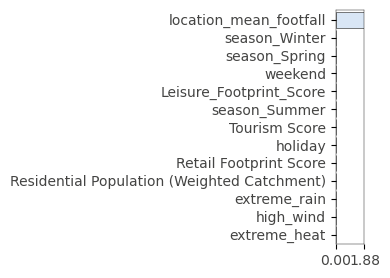

In [ ]:
imp = rfpimp.importances(rf_extreme_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### Add retail type

Get retail type dummies:

In [ ]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# drop unnecessary columns
df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName', 'supergroupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# calculate mean annual footfall for each location
location_means = df_model.groupby('Local_Footprint_Centre_ID')['events'].mean().rename('location_mean_footfall')

# merge it back to your dataframe
df_model = df_model.merge(location_means, on='Local_Footprint_Centre_ID')

# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score       680
rainfall           3976
tasmax             3976
tasmin             3976
mean_wind        132578
max_gust         132578
dtype: int64
Rows with at least one missing value: 135831
Total rows before drop: 437686
Total rows after drop: 301855


Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_') or col.startswith('groupName_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END .................max_depth=10, min_samples_split=10; total time=  26.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  29.0s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  29.7s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  30.0s
[CV] END .................max_depth=10, min_samples_split=10; total time=  29.6s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  32.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  35.0s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  36.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  36.0s
[CV] END .................max_depth=20, min_samples_split=10; total time=  34.7s
[CV] END .................max_depth=20, min_samples_split=10; total time=  34.9s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  36.5s
[CV] END ..................m

Implement random forest:

In [ ]:
rf_retail2 = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_retail2.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validated performance:

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained rf_retail2 model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_retail2,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_r2 = np.mean(cv_results['test_r2'])
std_r2 = np.std(cv_results['test_r2'])

mean_rmse = -np.mean(cv_results['test_rmse'])  # negate because it's negative by default
std_rmse = np.std(cv_results['test_rmse'])

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9440 ± 0.0003
Mean Train RMSE: 148.2348 ± 0.2792
Mean Test R²: 0.9360 ± 0.0013
Mean Test RMSE: 158.4842 ± 1.1040


Feature importance:

                                                    Importance
Feature                                                       
location_mean_footfall                                1.790734
season_Winter                                         0.050824
season_Spring                                         0.038346
weekend                                               0.012156
season_Summer                                         0.007309
Leisure_Footprint_Score                               0.004230
Residential Population (Weighted Catchment)           0.003129
holiday                                               0.001924
Tourism Score                                         0.001643
Retail Footprint Score                                0.001207
groupName_Indie high streets                          0.000555
groupName_Large regional retail and leisure des...    0.000347
groupName_Local urban convenience centres             0.000231
groupName_Mass and value high streets                 0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


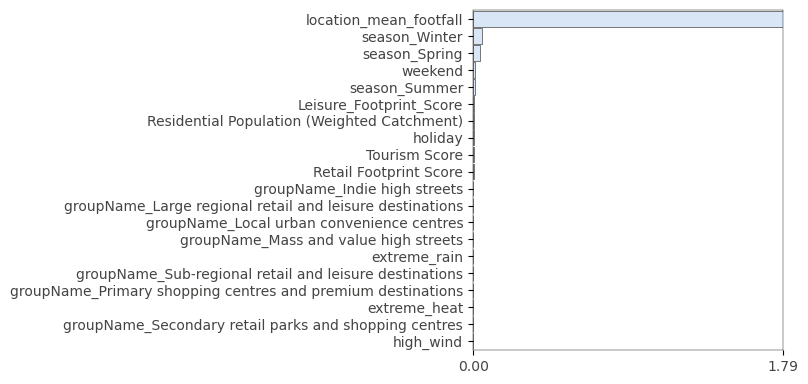

In [ ]:
imp = rfpimp.importances(rf_retail2, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Partial dependence plot:

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 17 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 18 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_depende

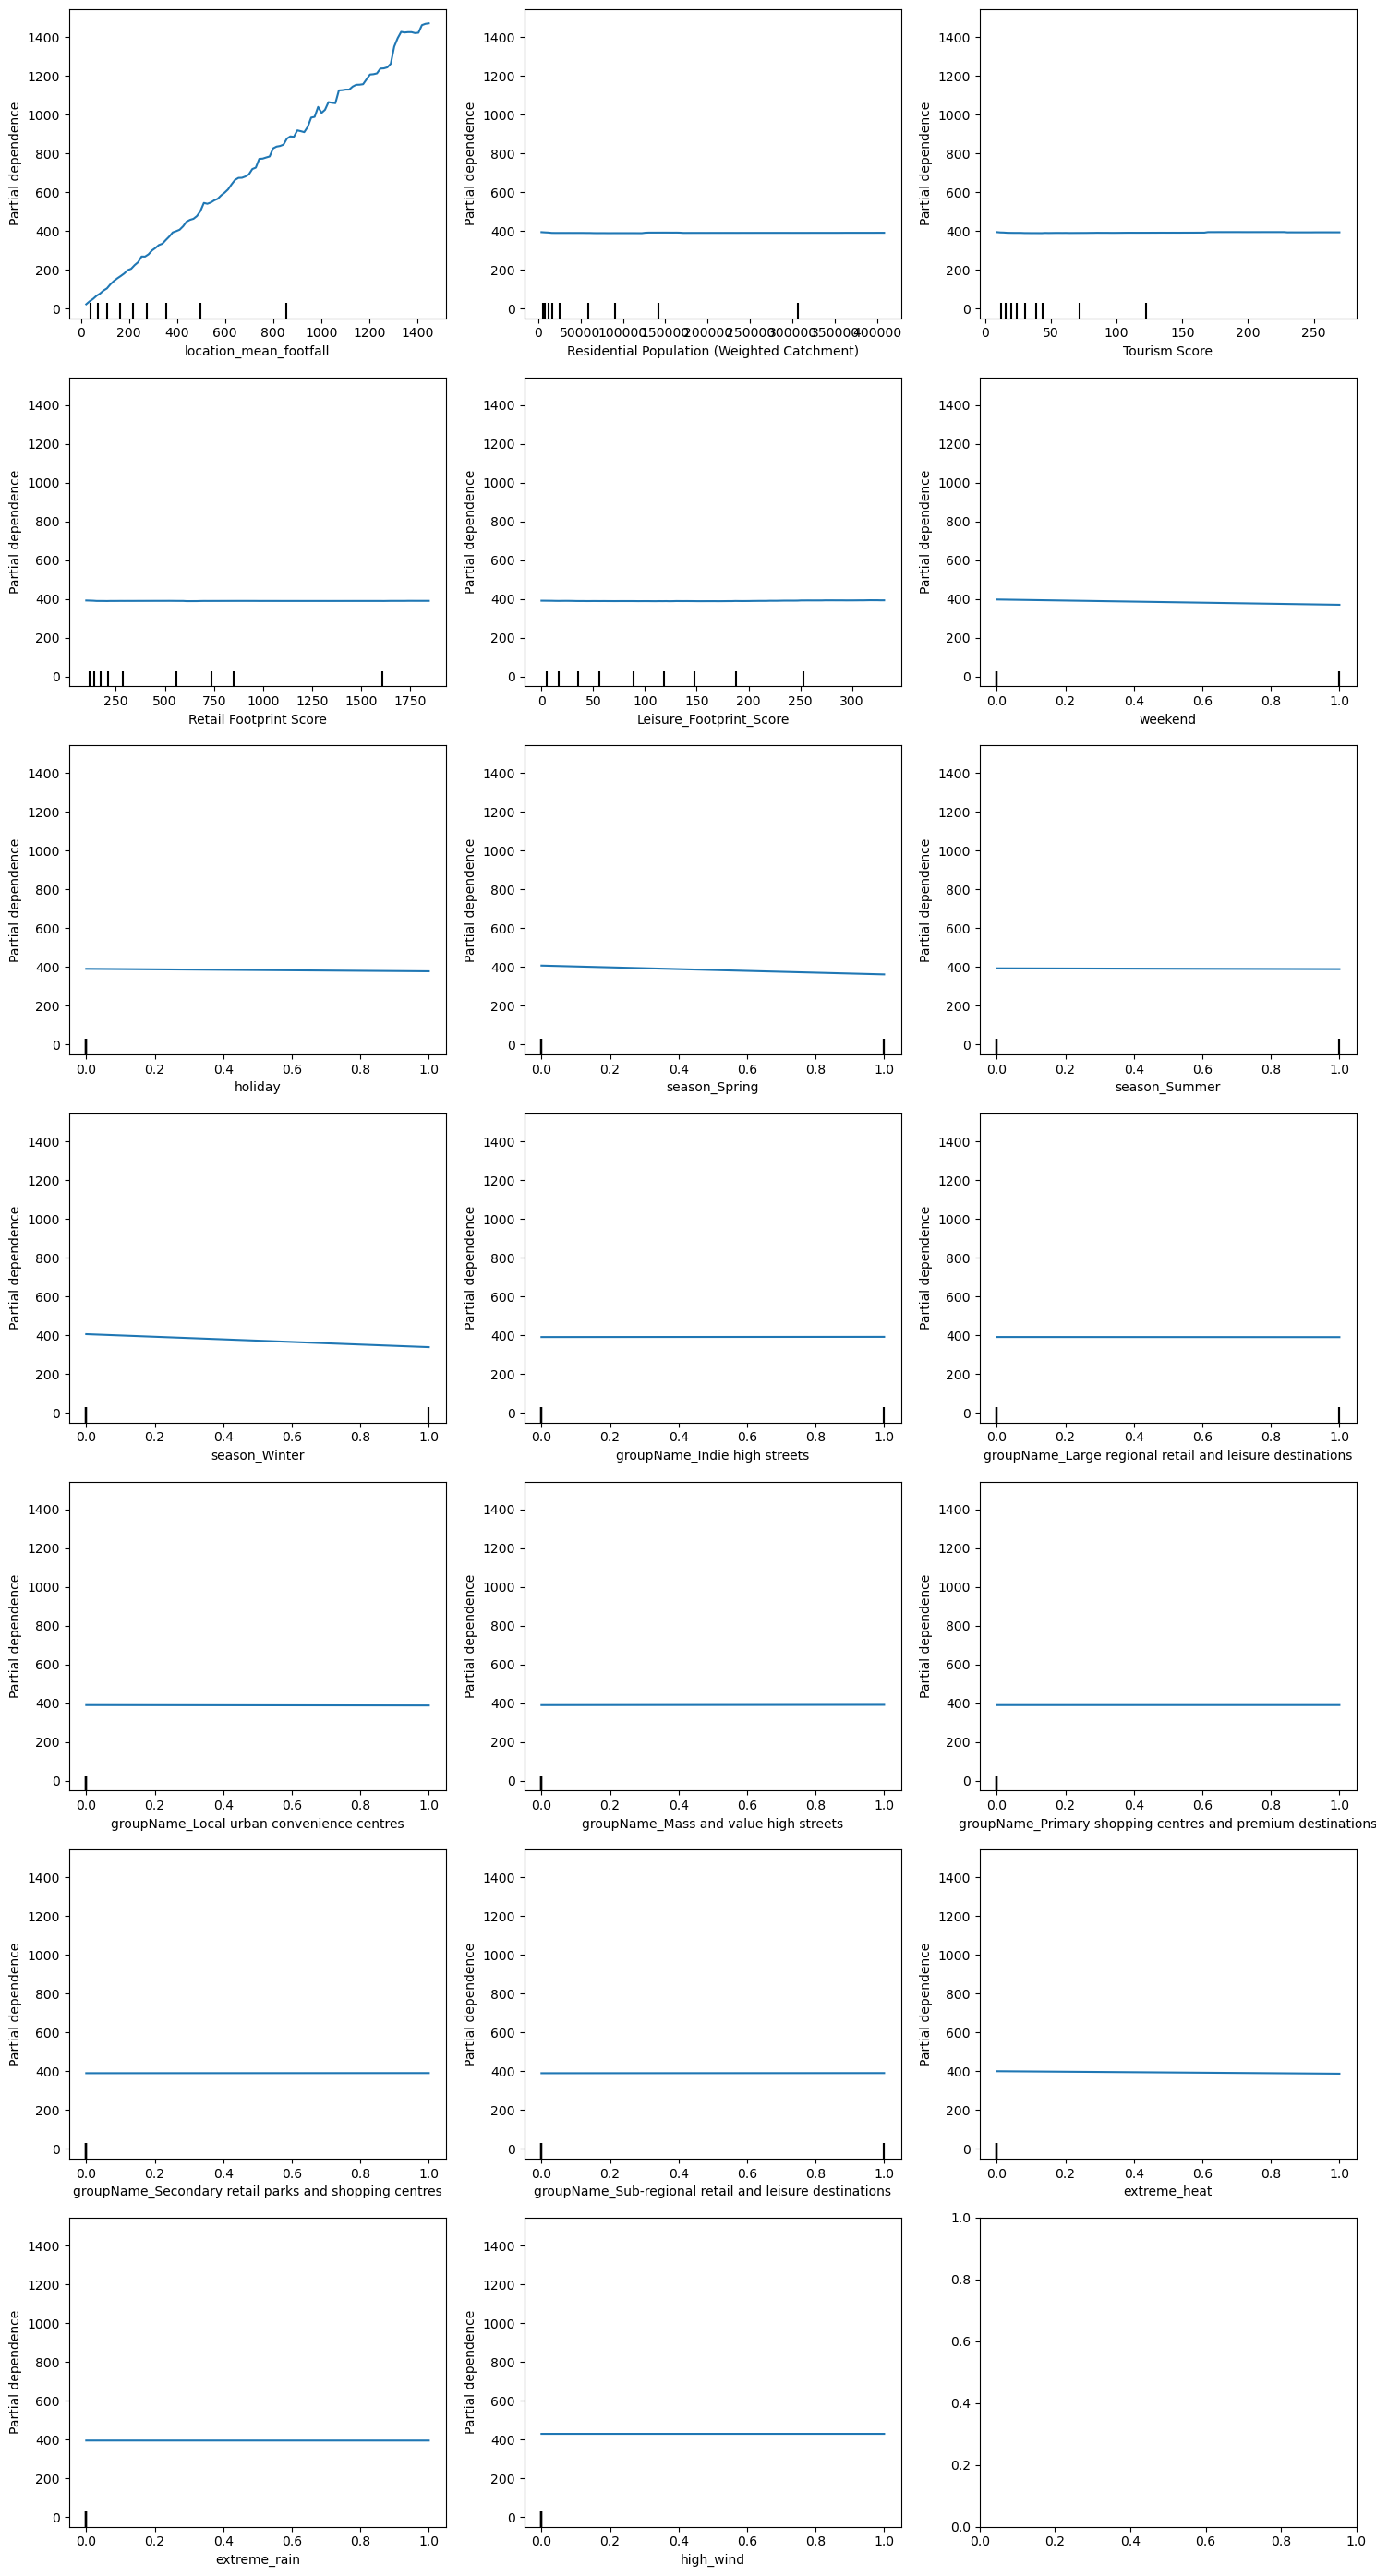

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# plot partial dependence for all features in train_x
features = train_x.columns.tolist() 

# create grid layout
n_features = len(features)
n_cols = 3
n_rows = -(-n_features // n_cols)  # ceiling division

fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax = ax.flatten()

# plot
PartialDependenceDisplay.from_estimator(
    rf_retail,
    train_x,
    features=features,
    ax=ax[:n_features]  # ensure ax isn't longer than the number of features
)

plt.tight_layout()
plt.show()

### 2.2.2 Extreme Weather

In [ ]:
# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

In [ ]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model.columns if col.startswith('season_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

Calibrated and cross-validated:

In [ ]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)

    # fit tuned model on full group data (not just train_x/y)
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    )

    # repeated k-fold cross-validation
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_results = cross_validate(
        model,
        group_data[features], group_data[target],
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize metrics
    mean_train_r2 = np.mean(cv_results['train_r2'])
    std_train_r2 = np.std(cv_results['train_r2'])

    mean_test_r2 = np.mean(cv_results['test_r2'])
    std_test_r2 = np.std(cv_results['test_r2'])

    mean_train_rmse = -np.mean(cv_results['train_rmse'])
    std_train_rmse = np.std(cv_results['train_rmse'])

    mean_test_rmse = -np.mean(cv_results['test_rmse'])
    std_test_rmse = np.std(cv_results['test_rmse'])

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {mean_train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {mean_train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {mean_test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {mean_test_rmse:.3f} ± {std_test_rmse:.3f}")

    # fit final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)

    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Repeated CV (15-fold):
Train R²: 0.960 ± 0.000
Train RMSE: 189.376 ± 0.898
Test R²: 0.955 ± 0.002
Test RMSE: 200.228 ± 3.738
Feature Importances:
location_mean_footfall                         0.953
season_Spring                                  0.011
season_Winter                                  0.010
Leisure_Footprint_Score                        0.006
weekend                                        0.006
Retail Footprint Score                         0.004
season_Summer                                  0.003
Residential Population (Weighted Catchment)    0.003
Tourism Score                                  0.002
holiday                                        0.001
extreme_rain                                   0.000
extreme_heat                                   0.000
high_wind                                      0.000
dtype: float64

Group: Indie high streets
Best parameters: {'max_d

KeyboardInterrupt: 

Partial dependence plots:

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

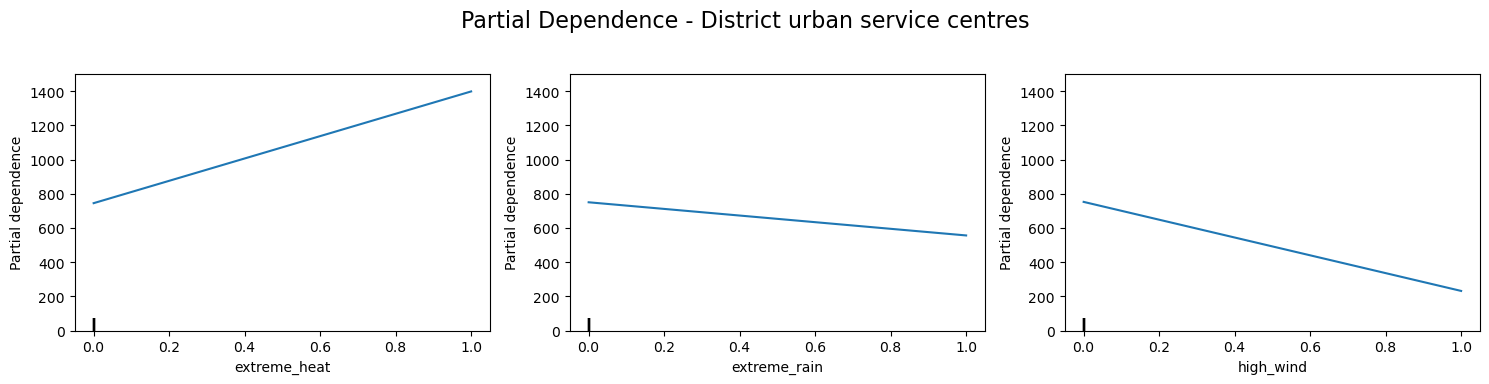

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

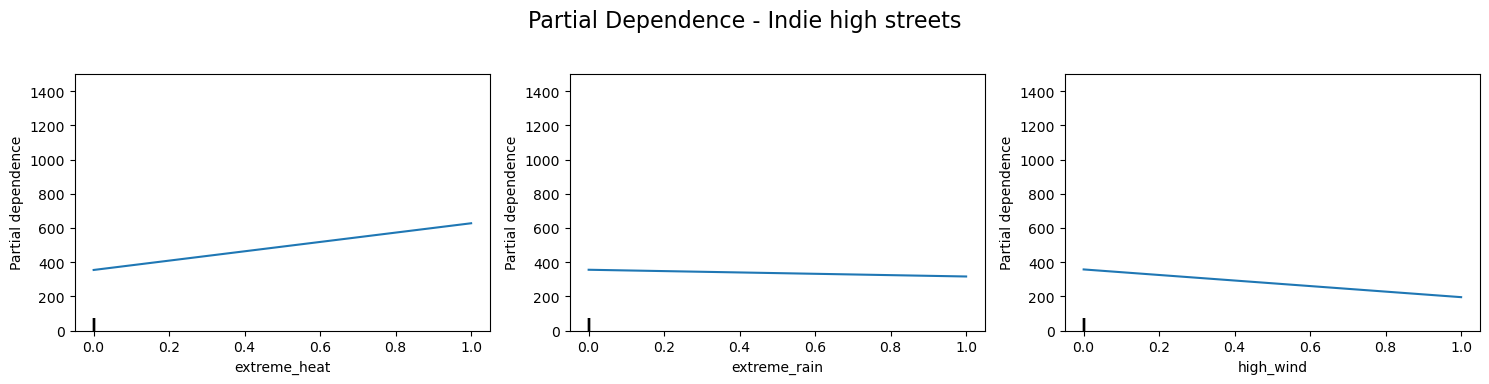

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

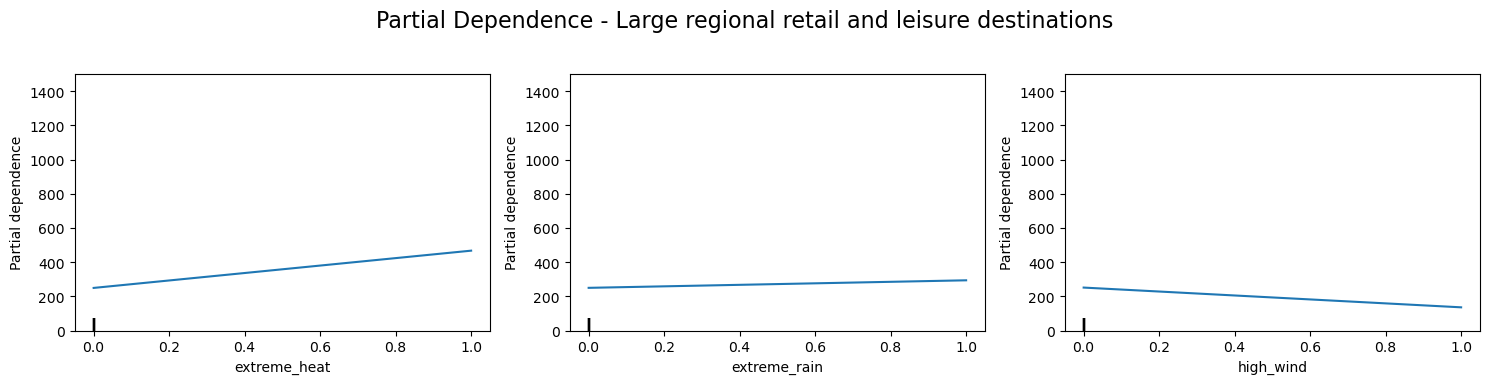

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

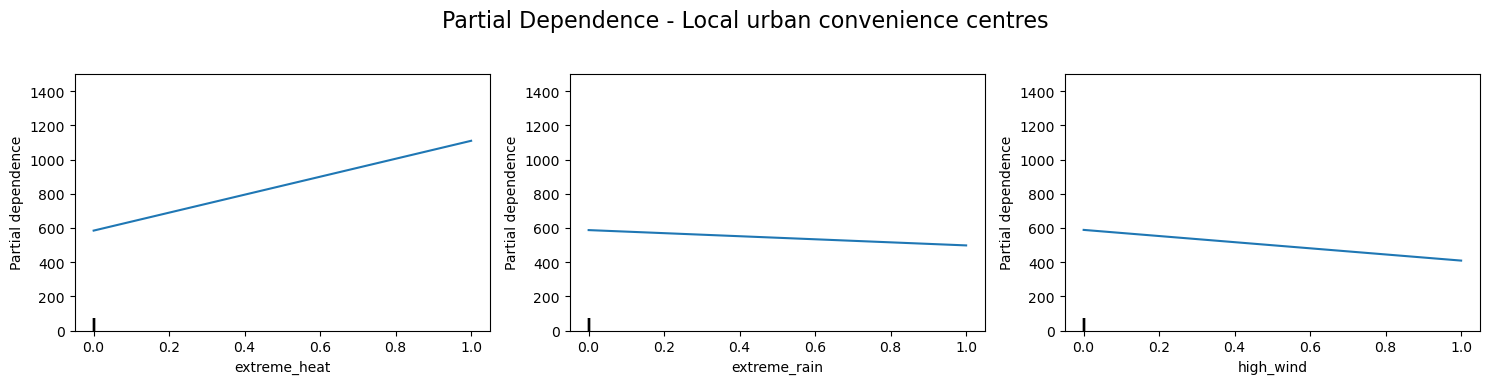

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

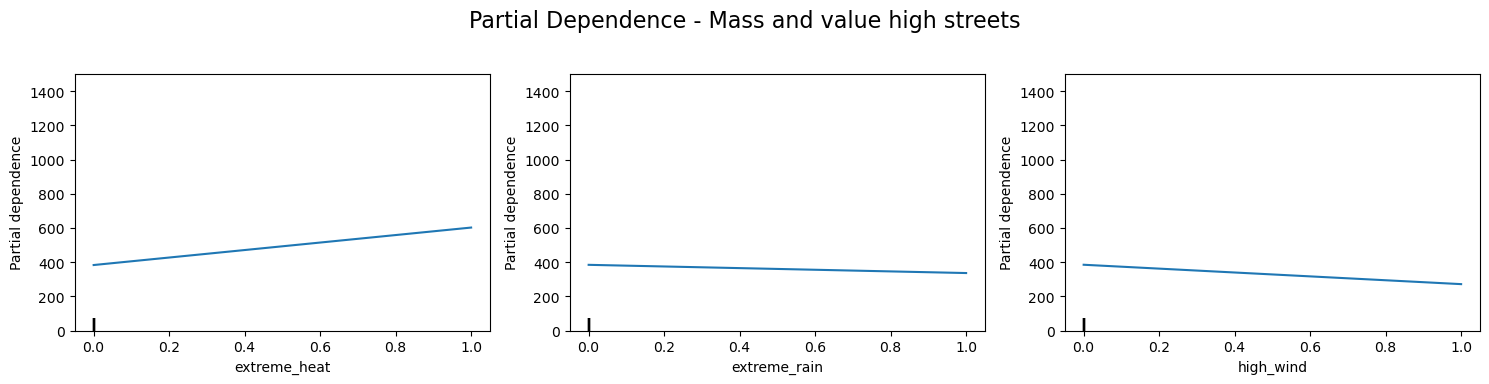

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

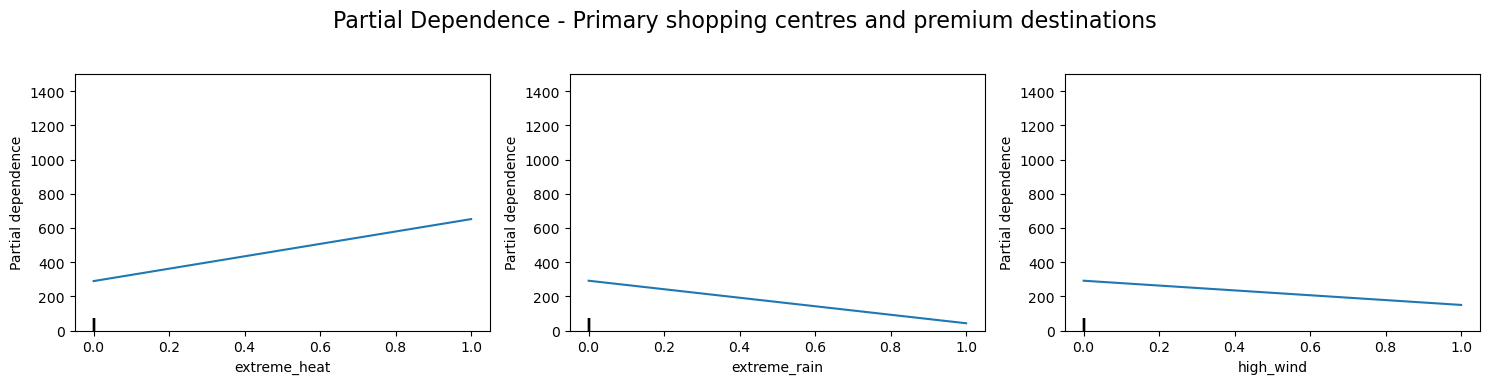

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

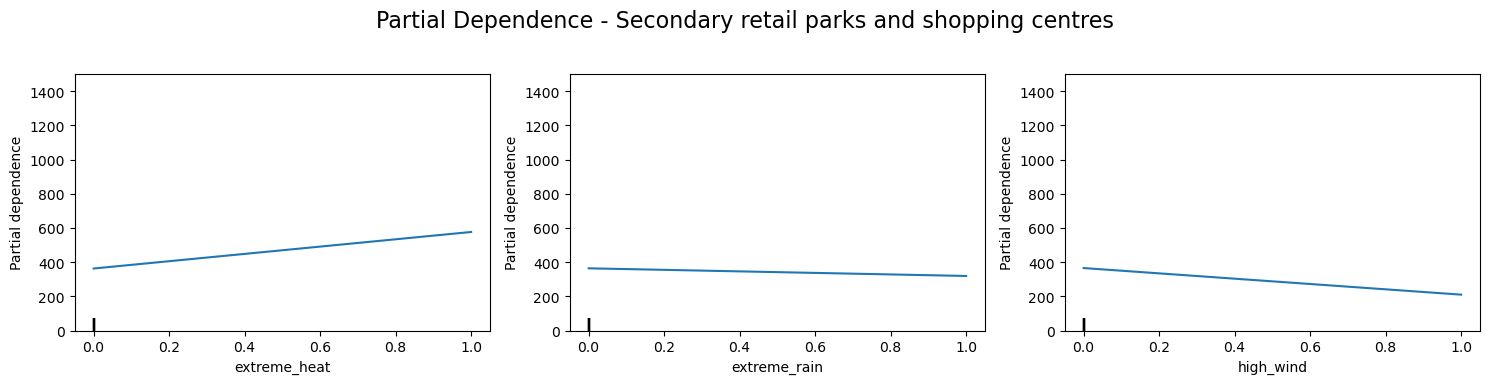

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

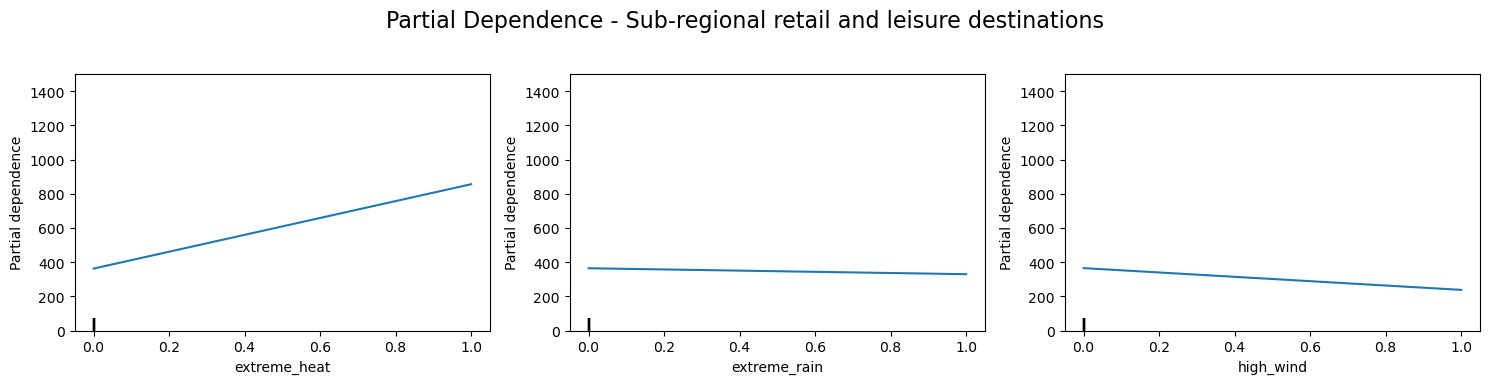

In [ ]:
weather_vars = ['extreme_heat', 'extreme_rain', 'high_wind']

for name, group_data in df_model.groupby('groupName'):
    if len(group_data) < 30:
        continue  # skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()